In [49]:
import numpy as np
import pickle as pkl
import bisect
import os
import torch
import pandas as pd
import math
from collections import Counter
import random
import random
import sys
approot=os.getcwd().strip('preprocessing')
sys.path.append(approot+'recommender_files')
from builddata import config_data, get_res
import recsys_v2 
from recsys_v2 import create_recsys
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
%matplotlib inline

approot=os.getcwd().strip('preprocessing')
city='Los_Angeles'

with open(approot+'good_data/Los_Angeles/loc_info.pkl','rb') as f:
    loc_info=pkl.load(f)

    
def remove_reviews(bla):
    return [x for x in bla if 'Reviews' not in x]

loc_info_clean={x: remove_reviews(loc_info[x][1]) for x in loc_info.keys()}    

with open(approot+'good_data/style_mapper.pkl','rb') as f:
    style_mapper=pkl.load(f)
    
site_index=pkl.load(open(approot+'good_data/Los_Angeles/site_index.pkl','rb'))


# Making Predictions w/ Real Data

Now we need to run this with some real data.  Below we have some functions to clean the data.  The data is coming from https://www.tripadvisor.com/ and https://trip.sftravel.com/.

In [50]:
def get_res():
    results=[]
    for k in range(0,13700,100):
        with open(f'/Users/williamcottrell72/MyGit/TravelApp/preprocessing/raw_data/Los_Angeles/file_{k}.pkl','rb') as f:
            likes=pkl.load(f)
            results.append(likes)

    # Now we need to combine all the results above into one big dictionary.    

    res=results[0]
    for i in range(1,len(results)):
        res={**res,**results[i]}
    return res


def clean_res(res):
    keys=list(res.keys())
    new_dct={}
    for i in range(len(keys)):
        dct=res[keys[i]]['ratings']
        n=len(city)+2
        new={x[n:]:dct[x] for x in dct if x[n:] in site_index}
        if len(new)!=0:
            new_dct[keys[i]]=new
    return new_dct

In [51]:
def make_matrix(res):
    user_list=list(res.keys())
    
    matrix=[]
    for u in user_list:
        user_likes=[]
        for p in site_index:
            if p in res[u].keys():
                user_likes.append(res[u][p])
            else:
                user_likes.append(float('NaN'))
        if sum(np.nan_to_num(user_likes,0))!=0:          
            matrix.append(user_likes)

    return np.array(matrix), user_list

In [52]:
def make_user_profiles(matrix,loc_info_clean):
    profiles={}
    
    for u in range(len(matrix)):
        features_list=[]
        for i in range(len(matrix[0])):
            try:
                features_list+=int(matrix[u][i])*(loc_info_clean[site_index[i]])
            except:
                features_list+=''

        new_features=[]
        for f in features_list:
            try:
                nf=style_mapper[f]
                if type(nf)==str:
                    new_features.append(nf)
                else:
                    new_features+=nf
            except:
                pass

        ct=Counter(new_features)
        norm=np.linalg.norm(list(ct.values()))
        tot=sum(ct.values())

#         res={k:10*ct[k]/norm for k in ct.keys()}
        #Use the line above if we want to normalize everything to a total of 10, else, use below.
        #Not normalizing kinda makes sense because we can give more weight to those who have travelled
        #more and reviewed more places... these people are more likely to be traveling and use the app 
        #anyway.
        
        res={k:ct[k] for k in ct.keys()}
        profiles[u]=res
    return profiles


def convert_profiles_to_np(profiles,attributes=['Nature','History','Culture','Life']):
    
    #Where does matrix come from?
    np_profiles=[]
    for u in range(len(profiles)):
        user_profile=[]
        for a in attributes:
            if a in profiles[u].keys():
                user_profile.append(profiles[u][a])
            else:
                user_profile.append(0)
        np_profiles.append(user_profile)
        
    return np.array(np_profiles)



def make_place_profile(site_index,loc_info_clean,style_mapper):
    place_profile=[]
    for p in site_index:
        try:
            loc_info=loc_info_clean[p]
            new_labels=[]
            for label in loc_info:

                sml=style_mapper[label]

                if type(sml)==list:
                    new_labels+=sml
                else:
                    new_labels+=[sml]
                    pass
                #print(new_labels)
            ct=Counter(new_labels)
            place_profile.append(np.array([ct['Nature'],ct['History'],ct['Culture'],ct['Life']]))
        except:
            place_profile.append(np.array([0,0,0,0]))
    return place_profile

In [53]:
matrix, user_list = make_matrix(res)

In [54]:
place_profiles=make_place_profile(site_index,loc_info_clean,style_mapper)


user_profiles=make_user_profiles(matrix,loc_info_clean)
np_profiles=convert_profiles_to_np(user_profiles)

np_profiles_normalized=pd.DataFrame(np_profiles).apply(lambda x: convert_to_cdf(x,0,10),axis=0)

In [55]:
matrix

array([[nan,  4., nan, ..., nan, nan, nan],
       [nan, nan,  3., ..., nan, nan, nan],
       [nan, nan,  5., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan],
       [nan, nan,  4., ..., nan, nan, nan]])

In [56]:
def convert_to_cdf(array,minimum,maximum):
    new=[]
    for x in array:
        index=(maximum-minimum)/(len(array))*(bisect.bisect_left(sorted(array),x))
        new.append(index)
    return np.array(new)



def config_data(res, loc_info_clean, style_mapper):
    

    
    # first, use get_data to construct a matrix, user list and place list appearing in the
    # user reviews.
    
    matrix, user_list = make_matrix(res)
    
    #next, build the user profiles based off of their reviews.
    
#     loc_info_clean={x: remove_reviews(loc_info[x][1]) for x in loc_info.keys()}
    
    # The function 'make_place_arrays' is essentially just `passing through'. The reason
    # this is done is to ensure that the input and output is consistent with the other
    # data.
    
    
#     mpp = make_place_arrays(places,loc_info_clean,style_mapper)
#     full_profiles, full_place_list, unreviewed_places = mpp
    
    place_profiles=make_place_profile(site_index,loc_info_clean,style_mapper)
    
    
    user_profiles=make_user_profiles(matrix,loc_info_clean)
    np_profiles=convert_profiles_to_np(user_profiles)
    
    np_profiles_normalized=pd.DataFrame(np_profiles).apply(lambda x: convert_to_cdf(x,0,10),axis=0)
    
    # next, we clean up places and add in a string of zeros for all the places which the
    # users (all of them) have not been to.
    
#     places_clean=[x[15:] for x in places]
#     padding=len([x for x in loc_info_clean.keys() if x not in places_clean and 'tour' not in x.lower() and x in site_index])  
#     zeros=np.zeros((len(matrix),padding))
    new_matrix=np.concatenate((np_profiles_normalized,matrix),axis=1)

    
    
    return user_profiles, new_matrix, place_profiles

In [57]:
res=clean_res(get_res())

In [58]:
user_profiles, matrix, place_profiles=config_data(res, loc_info_clean, style_mapper)

In [28]:
# profiles=make_user_profiles(matrix,loc_info)
# np_profiles=convert_profiles_to_np(profiles)

In [16]:
with open('good_data/place_profiles_light.pkl','wb') as f:
    pkl.dump(place_profiles, f)

In [3]:
# pkl.dump(data,open('tmp_data/data','wb'))
data=pkl.load(open('tmp_data/data','rb'))

In [8]:
test_real=create_recsys(matrix,max_iter=500,lr=.01,epochs=8,batch_size=200,latent_features=12)
test_real.fit()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8


In [12]:
# with open('good_data/full_place_list.pkl','wb') as f:
#     pkl.dump(full_place_list,f)
    
    
# with open('good_data/place_profiles.pkl','wb') as f:
#     pkl.dump(full_place_profiles,f)

torch.save(test_real.state_dict(),'model/model_cdf_light')
    
# sample_indices=np.random.choice(range(len(data[1][0])),17,replace=False)
# sample=data[1][sample_indices]
# test_real.forward(sample)

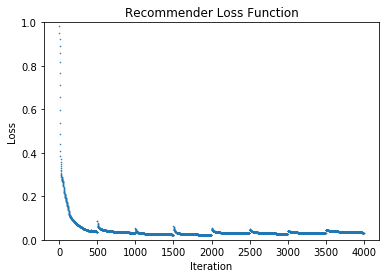

In [17]:
plt.scatter(list(range(len(test_real.losses))),test_real.losses,s=.3)
# plt.scatter(list(range(len(old_losses))),old_losses,s=.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.title("Recommender Loss Function")
plt.show()

In [64]:
path=approot+'good_data/San_Francisco/final_attractions_dict.pkl'

In [65]:
with open(path,'rb') as f:
    fad=pkl.load(f)

In [66]:
fad

{'Alcatraz Island': [{'formatted_address': 'Pier 33, The Embarcadero, San Francisco, CA 94133, USA',
   'geometry': {'location': {'lat': 37.8065278, 'lng': -122.4049402},
    'viewport': {'northeast': {'lat': 37.80781022989272,
      'lng': -122.4036488701073},
     'southwest': {'lat': 37.80511057010727, 'lng': -122.4063485298927}}},
   'id': '1afb6f264e19770aba59de21fd0d4cad027a1fb6',
   'name': 'Alcatraz Landing',
   'opening_hours': {'open_now': True},
   'photos': [{'height': 3024,
     'html_attributions': ['<a href="https://maps.google.com/maps/contrib/111182014407145234548/photos">Efraim Petel</a>'],
     'photo_reference': 'CmRaAAAA6oADAvyz7QIjAMUJF5qFfATSwNkHXPFGblwKmLlUtU7Oi8S6inKqbwNThdG46CNdj3ypxoYO9Qe8MQ5JGKiPr8R356K10CGiZppFkP532VRuZZVcwkfGebX-35nYIdeVEhDXKmkoNuKQEW-cjuUHklFUGhSol2kq6wHPucX3ytO1YluvNK08sw',
     'width': 4032}],
   'place_id': 'ChIJz1LKBvmAhYARFdpe008kIVU',
   'rating': 4.6,
   'types': ['point_of_interest', 'establishment']}],
 'Golden Gate Bridge': [{'